time_feat_update_v2

In [1]:
import numpy as np
import pandas as pd
df1 = pd.read_csv('merged-df.csv')  
df2 = pd.read_csv('final_features_with_clusters.csv')  

df1['date'] = pd.to_datetime(df1['date'])
df1['year_month'] = df1['date'].dt.to_period('M')  

expense = (
    df1[df1['amount'] > 0]
    .groupby(['user_id', 'year_month'])['amount']
    .mean()
    .reset_index()
    .rename(columns={'amount': 'mean_expense'})
)


expense['year_month'] = expense['year_month'].dt.to_timestamp()

In [2]:
expense = (
    df1[df1['amount'] > 0]
    .groupby(['user_id', 'year_month'])['amount']
    .mean()
    .reset_index()
    .rename(columns={'amount': 'mean_expense'})
)


expense['year_month'] = expense['year_month'].dt.to_timestamp()

In [3]:
check_expense = expense.groupby('user_id').size().reset_index(name='counts')

In [4]:
expense['year_month'] = pd.to_datetime(expense['year_month'])

txn_monthly = (
    df1.groupby(['user_id', df1['date'].dt.to_period('M')])
    .agg(
        txn_count=('transaction_id', 'count'),
        total_expense=('amount', lambda x: x[x > 0].sum()))
    .reset_index()
)
txn_monthly['year_month'] = txn_monthly['date'].dt.to_timestamp()
txn_monthly = txn_monthly.drop(columns=['date'])

txn_monthly = txn_monthly.sort_values(['user_id', 'year_month'])
txn_monthly[['txn_count_prev', 'total_expense_prev']] = (
    txn_monthly.groupby('user_id')[['txn_count', 'total_expense']].shift(1)
)

In [5]:
monthly_enhanced = pd.merge(
    expense,
    txn_monthly[['user_id', 'year_month', 'txn_count_prev', 'total_expense_prev']],
    on=['user_id', 'year_month'],
    how='left'
)

monthly_enhanced = monthly_enhanced.sort_values(['user_id', 'year_month']).reset_index(drop=True)
monthly_enhanced = monthly_enhanced.fillna(0)

In [6]:
result = monthly_enhanced.merge(df2, on='user_id', how='left')
result = result.sort_values(['user_id', 'year_month']).reset_index(drop=True)
result[[ 'mean_expense']] = result[['mean_expense']].round(1)

In [7]:
long_df = pd.melt(
    result,
    id_vars=[
        'user_id', 
        'year_month',
        'txn_count_prev', 
        'total_expense_prev'
    ],  
    value_vars=['mean_expense'],  
    var_name='type',            
    value_name='mean_amount'     
)

long_df['type'] = long_df['type'].str.replace('mean_', '')
long_df = long_df.sort_values(['user_id', 'year_month', 'type']).reset_index(drop=True)
final_df = long_df.merge(df2, on='user_id', how='left')

In [8]:
cols_to_drop = [
    'year_month', 'type',
    'total_txn_count', 'total_amount', 'avg_amount', 'std_amount',
    'median_amount', 'first_txn', 'last_txn',
    'user_birth_year', 'user_retirement_age', 'trend_category'
]

final_df = final_df.drop(columns=cols_to_drop, errors='ignore')
final_df['user_gender'] = final_df['user_gender'].replace({'Male': 0, 'Female': 1})
final_df['risk_level'] = final_df['risk_level'].replace({'Low': 0, 'Medium': 1,'High':2})
final_df = final_df.round(1)

C:\Users\Suzreal\AppData\Local\Temp\ipykernel_31336\2619023033.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df['user_gender'] = final_df['user_gender'].replace({'Male': 0, 'Female': 1})
C:\Users\Suzreal\AppData\Local\Temp\ipykernel_31336\2619023033.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df['risk_level'] = final_df['risk_level'].replace({'Low': 0, 'Medium': 1,'High':2})


In [9]:
final_df['percentage_prev_monthly_expense_as_yearly'] = ((final_df['total_expense_prev'] / final_df['user_yearly_income']) * 100).fillna(0).round(1)

final_df['percentage_prev_monthly_expense_as_capita'] = ((final_df['total_expense_prev'] / final_df['user_per_capita_income']) * 100).replace([np.inf, -np.inf], np.nan).fillna(0).round(1)

In [18]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139367 entries, 0 to 139366
Data columns (total 28 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   user_id                                    139367 non-null  int64  
 1   txn_count_prev                             139367 non-null  float64
 2   total_expense_prev                         139367 non-null  float64
 3   mean_amount                                139367 non-null  float64
 4   user_gender                                139367 non-null  int64  
 5   user_current_age                           139367 non-null  int64  
 6   user_yearly_income                         139367 non-null  float64
 7   user_per_capita_income                     139367 non-null  float64
 8   user_credit_score                          139367 non-null  int64  
 9   user_total_debt                            139367 non-null  float64
 10  user_bir

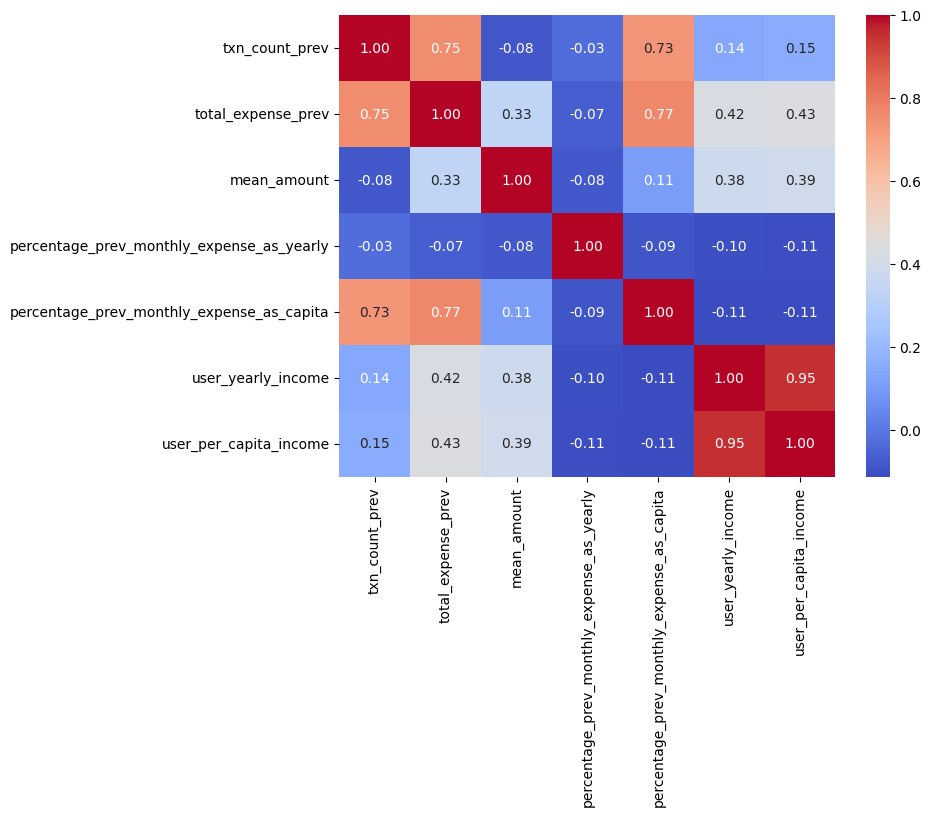

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

X = final_df[['txn_count_prev', 'total_expense_prev', 'mean_amount','percentage_prev_monthly_expense_as_yearly',
       'percentage_prev_monthly_expense_as_capita','user_yearly_income','user_per_capita_income']]
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [20]:
final_df.to_csv('time_feat_no_negative.csv', index=False)